In [1]:
library(tidyverse)
library(cowplot)
library(martini)
library(blur)

theme_set(theme_cowplot())
results <- '../results/'

gene2snp <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = "cc")
load(paste0(results,'scones/gi_network.RData'))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



# GS network

In [2]:
gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli")
sum(gs$selected)

[1] 1590

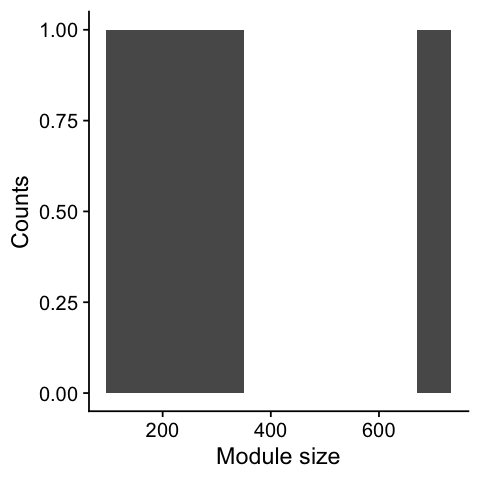

In [3]:
options(repr.plot.width=4, repr.plot.height=4)
module_size(gs)

Most of the clusters have small sizes (1,2 SNPs). However, it seems that small clusters have a similar association scores as bigger clusters, so I am inclined to think that bigger clusters are not picked despite being having lower association scores, but because they happen to connect high-score SNPs.

In [4]:
blur:::compute_mod_size(gs)

module,chr,size,C
<int>,<int>,<int>,<dbl>
1,3,690,5.843032
3,8,316,5.396481
2,5,258,9.333046
4,10,210,5.429173
5,16,116,5.798756


It seems that the biggest clusters come from only 3 chromosomic regions in chromosomes 3, 5 and 8.

[1] TRUE

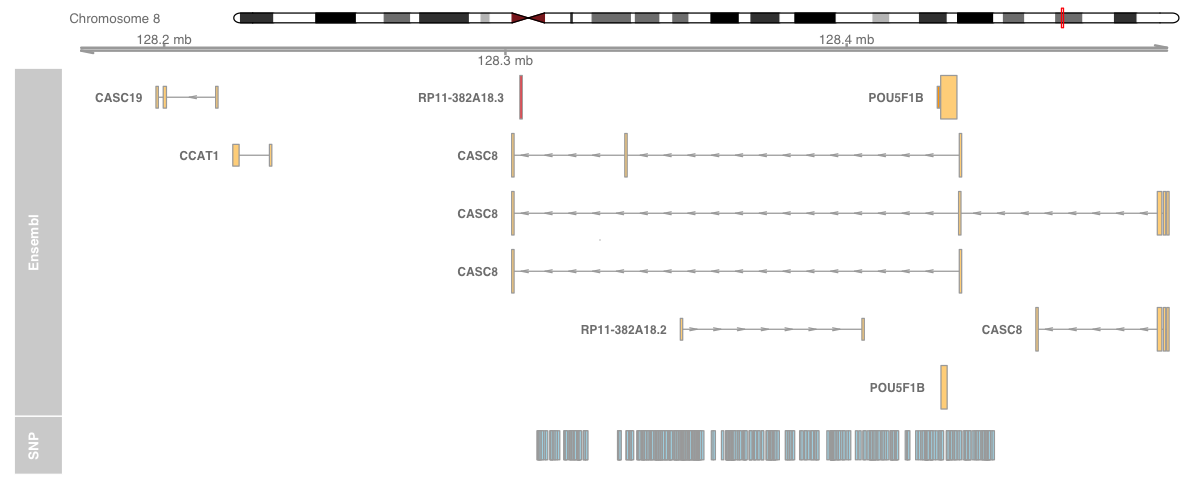

In [5]:
options(repr.plot.width=10, repr.plot.height=4)
k <- blur:::compute_mod_size(gs) %>% filter(chr == 8) %>% .$module %>% head(n = 20)
plot_snp_module(gs, k)

In chromosome 8 we find gene CASC8, which had appreared in previous analyses.

[1] TRUE

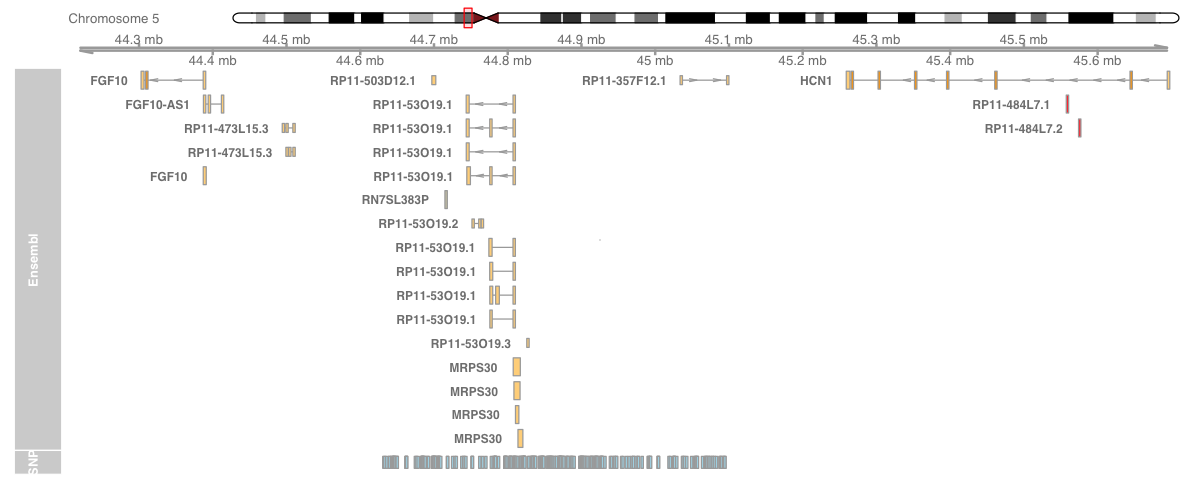

In [6]:
options(repr.plot.width=10, repr.plot.height=4)
k <- blur:::compute_mod_size(gs) %>% filter(chr == 5) %>% .$module %>% head(n = 20)
plot_snp_module(gs, k)

In this region we find two compelling genes: MRPS30, the S30 subunit of the mitochondrial ribosome and potentially involved in energetic metabolism; and, more interestingly, RP11-53O19.1, also known as Breast Cancer-Associated Transcript 54, a ncRNA.

[1] TRUE

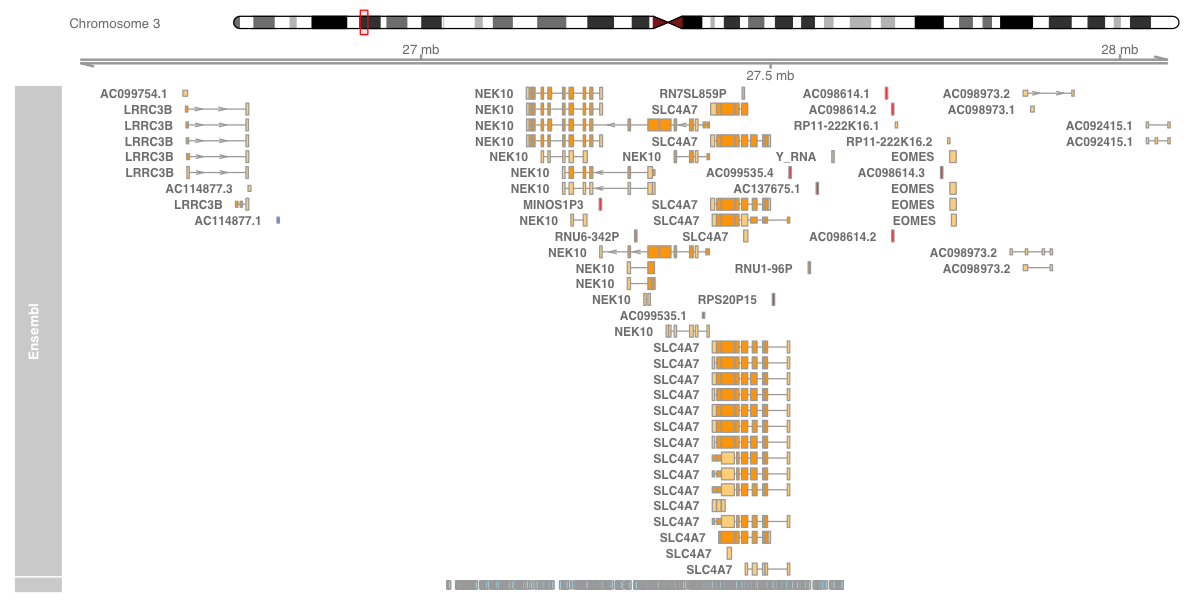

In [7]:
options(repr.plot.width=10, repr.plot.height=5)
k <- blur:::compute_mod_size(gs) %>% filter(chr == 3) %>% .$module %>% head(n = 20)
plot_snp_module(gs, k)

Here we retrieve our old-friend NEK10, a protein kinase involved in cell-cycle controlwhich was already linked to BRCA susceptibility.

## Genes affected

In [8]:
table_regions(gs, net)

region,module,coords,bestSnp,genes,numSnps
<chr>,<int>,<chr>,<chr>,<chr>,<chr>
3p24.1,1,27038340-27602278,rs6779140,"MICOS10P3,RNU6-342P,NEK10,RNU1-96P,RPS20P15",690 (111)
5p12,2,44632008-45094503,rs930395,"MRPS30-DT,LINC02224,RN7SL383P,MRPS30",258 (111)
8q24.21,3,128309591-128442944,rs9693995,PCAT1,316 (0)
10q26.13,4,123296158-123477629,rs2981579,"ATE1,FGFR2,RPS15AP5",210 (17)
16q12.1,5,52525285-52587375,rs12918816,TOX3,58 (0)
16q12.2,5,52600447-52651714,rs12922061,"CASC16,TOX3",58 (0)


When we don't focus on clusters, but try to see signal provided by any selected SNPs we give voice to these SNPs with an association strongly associated enough to be selected without a cluster. Like this, we recover our old friend FGFR2, a tumor suppressor gene that is amplified and overexpressed in breast cancer.

[1] TRUE

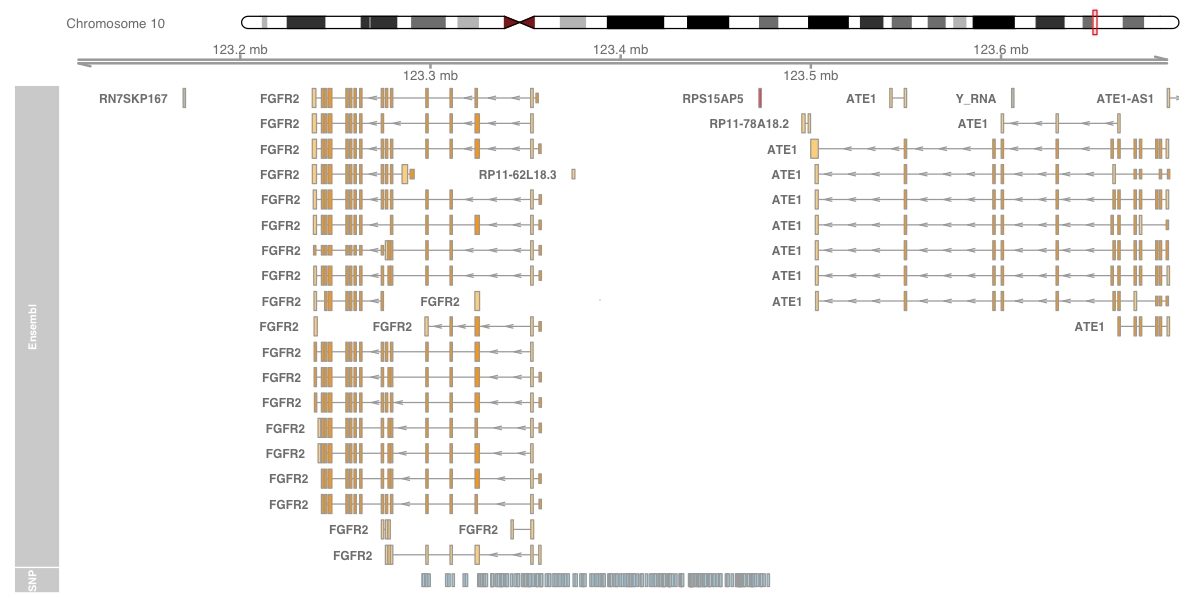

In [9]:
options(repr.plot.width=10, repr.plot.height=5)
# FGFR2 SNPs
k <- gs %>% filter(selected & chr == 10 & pos > 123296158 & pos < 123357561) %>% .$module
plot_snp_module(gs, k)

TOX3, related with ER+ BRCA, and CASC16, really close in the genome also pop up in the analysis.

[1] TRUE

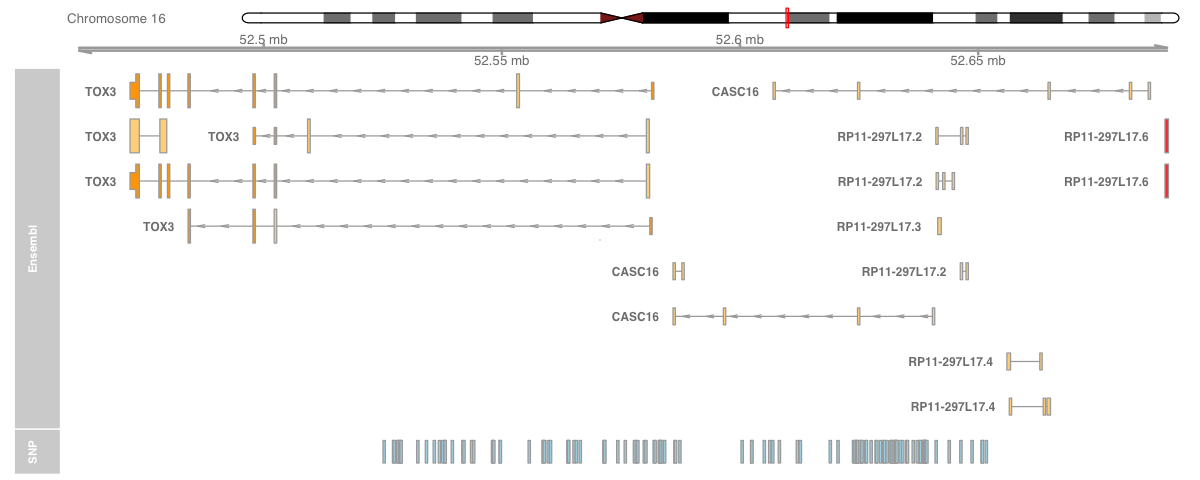

In [10]:
options(repr.plot.width=10, repr.plot.height=4)
# TOX3 SNPs
k <- gs %>% filter(selected & chr == 16 & pos > 52525285 & pos < 52639236) %>% .$module
plot_snp_module(gs, k)

# GM network

In [11]:
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli")
sum(gm$selected)

[1] 692

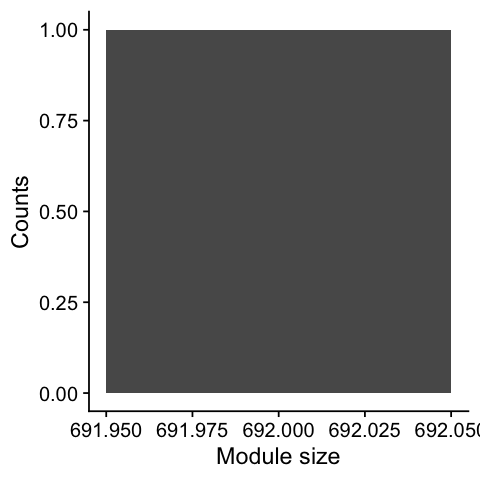

In [12]:
options(repr.plot.width=4, repr.plot.height=4)
module_size(gm)

In [13]:
blur:::compute_mod_size(gm)

module,chr,size,C
<int>,<int>,<int>,<dbl>
1,3,692,5.800495


Only 2 chromosomic regions here, in chromosomes 3 and 5, around the regions we already described.

[1] TRUE

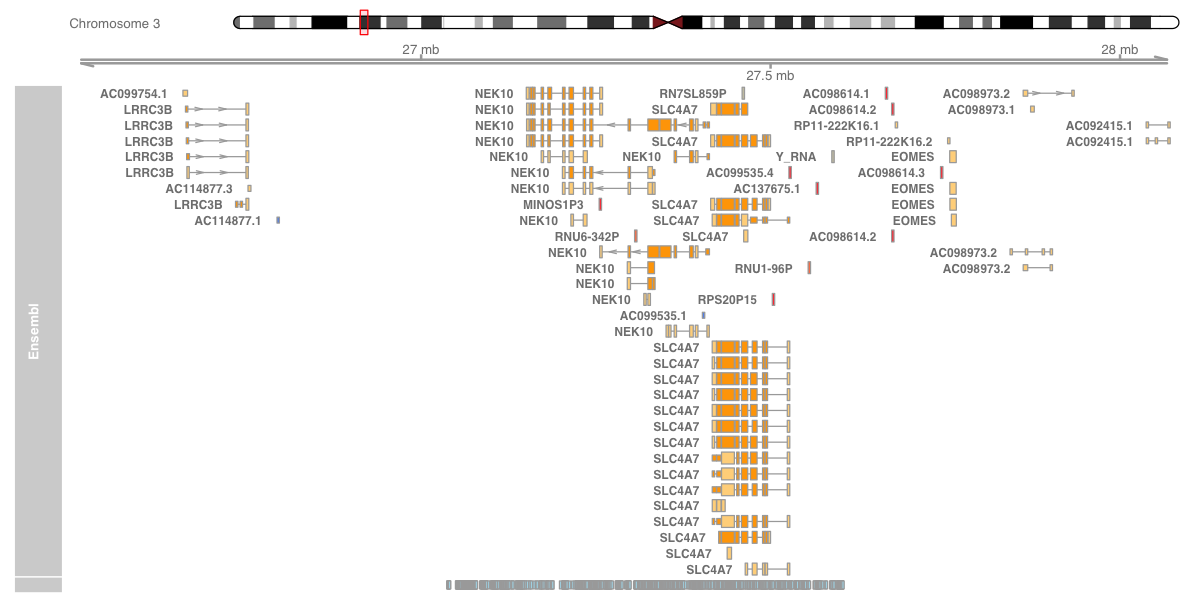

In [14]:
options(repr.plot.width=10, repr.plot.height=5)
k <- blur:::compute_mod_size(gm) %>% filter(chr == 3) %>% .$module %>% head(n = 20)
plot_snp_module(gm, k)

In [15]:
options(repr.plot.width=10, repr.plot.height=4)
k <- blur:::compute_mod_size(gm) %>% filter(chr == 5) %>% .$module %>% head(n = 20)
plot_snp_module(gm, k)

[1] TRUE

## Genes affected

In [16]:
table_regions(gm, net)

region,module,coords,bestSnp,genes,numSnps
<chr>,<int>,<chr>,<chr>,<chr>,<chr>
3p24.1,1,27038340-27603597,rs6779140,"MICOS10P3,RNU6-342P,NEK10,RNU1-96P,RPS20P15",692 (111)


# GI network

In [17]:
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdld")
sum(gi$selected)

[1] 7803

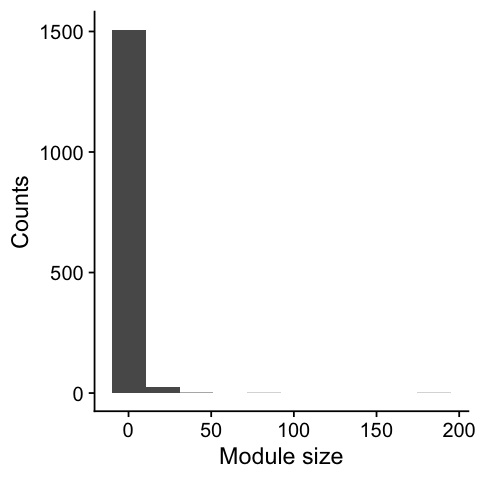

In [18]:
options(repr.plot.width=4, repr.plot.height=4)
module_size(gi)

In [19]:
head(blur:::compute_mod_size(gi))

module,chr,size,C
<dbl>,<int>,<int>,<dbl>
116,16,187,5.011463
198,2,84,3.074454
228,1,42,5.491482
50,10,33,15.631772
169,7,24,4.268616
605,4,24,4.770694


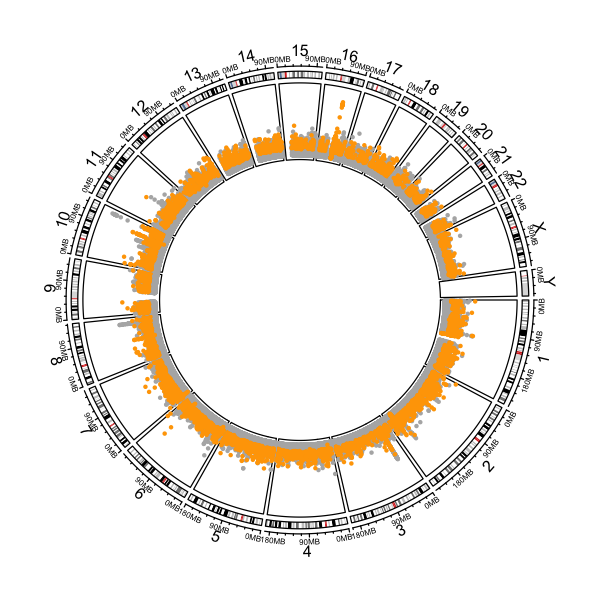

In [20]:
options(repr.plot.width=5, repr.plot.height=5)
plot_ideogram(gi)

We observe how modules span through different chromosomes.

In [21]:
suppressMessages(library(ggnetwork))
library(tidygraph)
net <- left_join(as_tbl_graph(net), gi, by = c("name" = "snp"))


Attaching package: 'tidygraph'

The following object is masked from 'package:stats':

    filter



Loading required package: sna
Loading required package: statnet.common

Attaching package: 'statnet.common'

The following object is masked from 'package:base':

    order

Loading required package: network
network: Classes for Relational Data
Version 1.15 created on 2019-04-01.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.

sna: Tools for Social Network Analysis
Version 2.4 created on 2016-07-23.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
 For citation information, type citation("sna").
 Type help(package="sna") to get started.



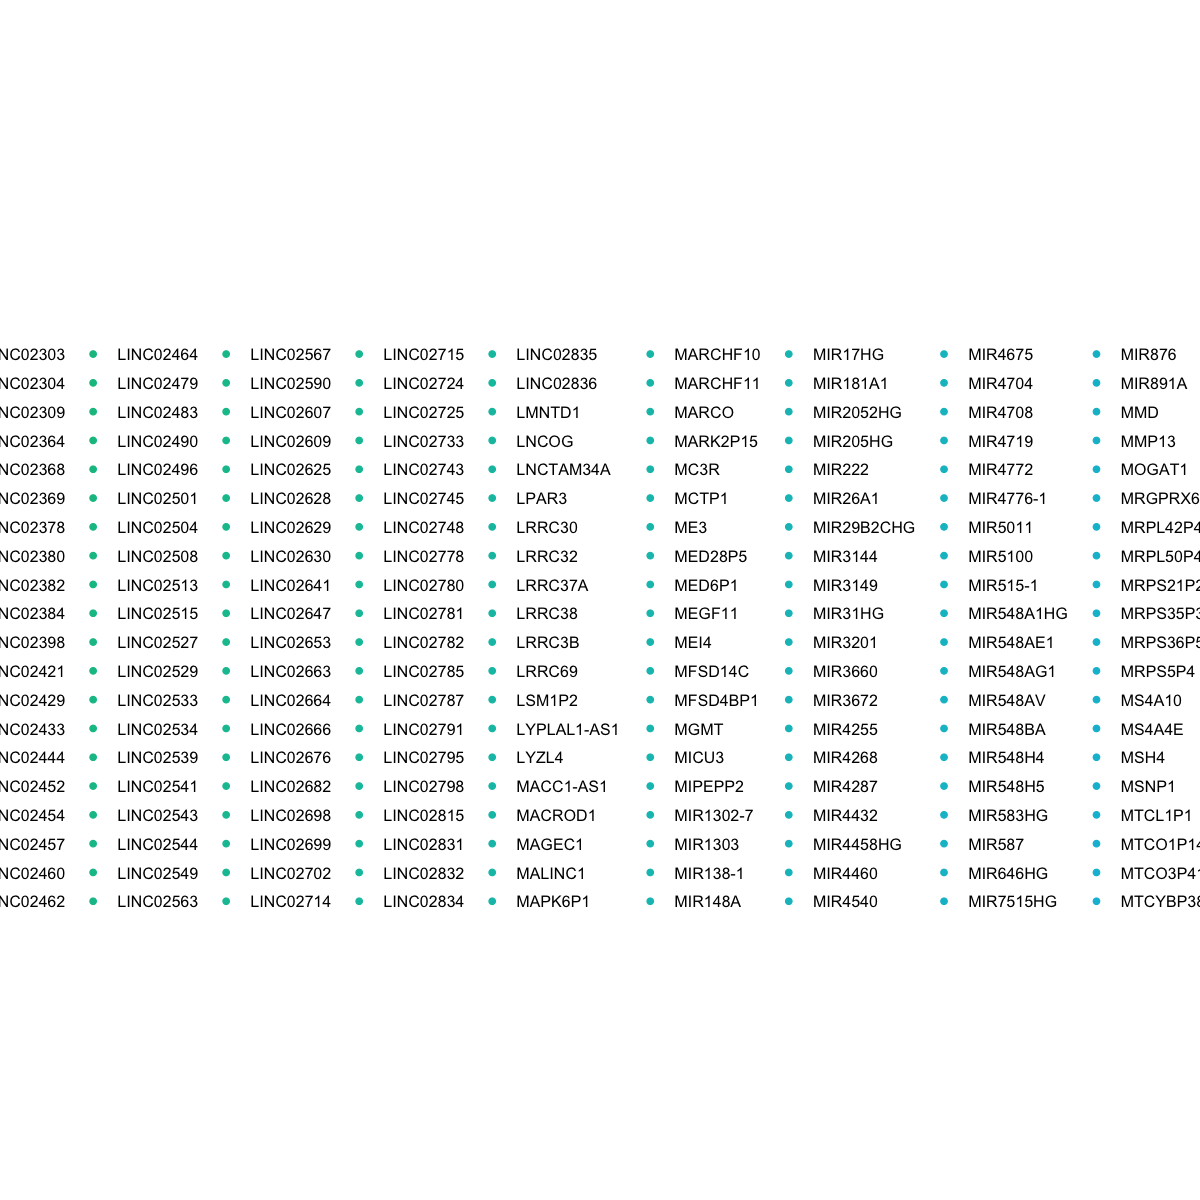

In [22]:
options(repr.plot.width=10, repr.plot.height=10)

filter(net, selected) %>%
    igraph::as.igraph() %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = "grey50") +
        geom_nodes(aes(color = gene)) +
        facet_wrap(~module) +
        theme_facet()

## Genes affected

In [23]:
table_regions(gi, net)

region,module,coords,bestSnp,genes,numSnps
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1p21.2,492,101849830-101858202,rs6577245,LINC01307,2 (0)
1p21.2,1345,101951693-101951693,rs1777871,,1 (1)
1p21.2,1346,101984932-101984932,rs263918,,1 (1)
1p21.1,1347,102661680-102661680,rs12063971,,1 (1)
1p21.1,1348,102740645-102743350,rs10158366,,2 (2)
1p21.1,1349,102866726-102866726,rs10747426,,1 (1)
1p21.1,1350,103110933-103113416,rs7533876,,2 (2)
1p21.1,1351,103627745-103627745,rs10127715,,1 (1)
1p21.1,1352,103757778-103757778,rs2222748,,1 (1)


One interesting gene that didn't pop up in previous experiments is DIRC3, associated to renal and thyroid carcinomas; the other is CCAT2, related to prostate cancer susceptibility

[1] TRUE

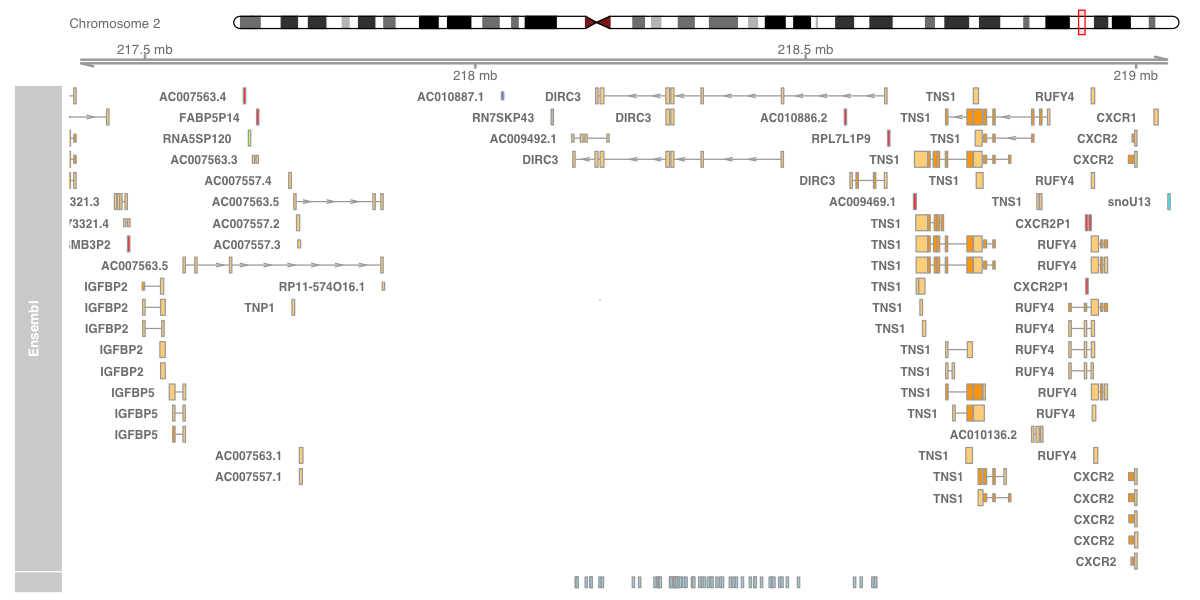

In [24]:
options(repr.plot.width=10, repr.plot.height=5)
DIRC3 <- filter(gi, selected & chr == 2 & pos > 218150948 & pos < 218606227)
plot_snp_module(DIRC3, DIRC3$module)

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
TMEM106B <- filter(gi, selected & chr == 7 & pos > 12251488 & pos < 12275818)
plot_snp_module(TMEM106B, TMEM106B$module)

[1] TRUE

In [26]:
options(repr.plot.width=10, repr.plot.height=3)
CCAT2 <- filter(gi, selected & chr == 8 & pos > 128413087 & pos < 128414371)
plot_snp_module(CCAT2, CCAT2$module)

[1] TRUE

# Consistency

How consistent are the selected SNPs in the different networks?

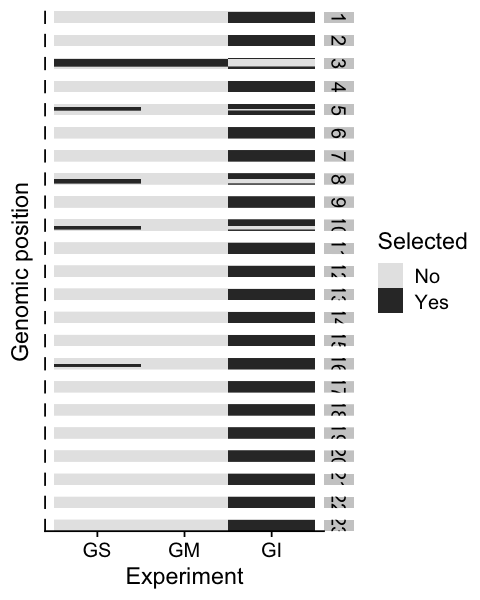

In [27]:
options(repr.plot.width=4, repr.plot.height=5)
consistency(GS = gs, GM = gm, GI = gi)

GI network selects twice as many SNPs as the GM and the GS networks. As we see, most of the SNPs selected in the GS are selected in GS, and most of the ones selected in GM (+ many more) are selected in GI. Interestingly, as we can see from the circos above, GI network provides a way of connecting the previously isolated chromosomic regions in 3, 5 and 8 (and some potentially interesting regions in chromosomes 10 and 16).

In [28]:
set_gs <- gs$snp[gs$selected]
set_gm <- gm$snp[gm$selected]
set_gi <- gi$snp[gi$selected]

length(intersect(set_gs, set_gm))/length(union(set_gs, set_gm))
length(intersect(set_gi, set_gs))/length(union(set_gi, set_gs))
length(intersect(set_gi, set_gm))/length(union(set_gi, set_gm))

[1] 0.4334171

[1] 0.02666958

[1] 0.004137116